## Question 1

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('debates_2022.csv')
df.head()

,Unnamed: 0,speaker_name,speaker_role,speaker_party,date,year,debate_title,talk_text
0,81414,Roberta Metsola,NaN,NaN,2022-01-17,2022,Resumption of the session,declaration repeats the session of the europe...
1,81415,Roberta Metsola,NaN,NaN,2022-01-17,2022,Memorial ceremony for President David Maria Sa...,it is with great sadness that today we are pr...
2,81416,Enrico Letta,NaN,NaN,2022-01-17,2022,Memorial ceremony for President David Maria Sa...,secretary of the italian democratic party and...
3,81417,Roberta Metsola,NaN,NaN,2022-01-17,2022,Memorial ceremony for President David Maria Sa...,there will be a musical interlude for a few mi...
4,81418,Charles Michel,NaN,NaN,2022-01-17,2022,Memorial ceremony for President David Maria Sa...,president of the european council. “mr. presi...


In [3]:
#remove short/empty transcripts

df = df[df['talk_text'].notnull()]
df = df[df['talk_text'].str.len() > 20]

In [4]:
texts = df['talk_text']

In [5]:
texts

0         declaration repeats the session of the europe...
1         it is with great sadness that today we are pr...
2         secretary of the italian democratic party and...
3        there will be a musical interlude for a few mi...
4         president of the european council. “mr. presi...
                               ...                        
14492                             that concludes the item.
14493    the minutes of this sitting will be submitted ...
14494    the next part-session will take place from 16–...
14495    let me wish you all merry christmas and happy ...
14496    i declare adjourned the session of the europea...
Name: talk_text, Length: 14494, dtype: object

In [8]:
def clean_and_normalize(text):
    # Convert to lowercase
    cleaned = text.lower()
    
    # Remove punctuation and special characters
    cleaned = re.sub(r'[^a-z\s]', '', cleaned)
    
    # Tokenize text into individual words
    tokens = nltk.word_tokenize(cleaned)
    
    # Filter out stopwords
    english_stops = set(stopwords.words('english'))
    filtered_tokens = [term for term in tokens if term not in english_stops]
    
    # Lemmatize tokens
    lemma_engine = WordNetLemmatizer()
    base_words = [lemma_engine.lemmatize(term) for term in filtered_tokens]
    
    # Reassemble processed words into a single string
    final_output = ' '.join(base_words)
    
    return final_output

processed_corpus = texts.apply(clean_and_normalize)

In [11]:
processed_corpus

0        declaration repeat session european parliament...
1        great sadness today preparing give last commit...
2        secretary italian democratic party former pres...
3        musical interlude minute musical interlude cel...
4        president european council mr president europe...
                               ...                        
14492                                       concludes item
14493    minute sitting submitted parliament approval b...
14494                  next partsession take place january
14495    let wish merry christmas happy new year behalf...
14496        declare adjourned session european parliament
Name: talk_text, Length: 14494, dtype: object

In [12]:
vectorizer = TfidfVectorizer(
    max_df=0.85,  # Ignore words that appear in more than 85% of talkss
    min_df= 5,     # Ignore words that appear in less than 5 talks
    ngram_range=(1, 1),  # Use unigrams
    stop_words='english',  # Remove common English stopwords
    max_features= 10000
)

In [13]:
X = vectorizer.fit_transform(processed_corpus)

In [14]:
X

<14494x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1106046 stored elements in Compressed Sparse Row format>

In [15]:
print("Features (Top 20):", vectorizer.get_feature_names_out()[:20])

Features (Top 20): ['abandon' 'abandoned' 'abandoning' 'abandonment' 'abdel' 'abduction'
 'aber' 'aberration' 'abhorrent' 'abide' 'abiding' 'ability' 'able'
 'abnormal' 'abolish' 'abolished' 'abolishing' 'abolition' 'abortion'
 'abraham']


In [16]:
# Convert the matrix to a DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Display the top few rows of the TF-IDF DataFrame
print(tfidf_df.head())

    abandon  abandoned  abandoning  abandonment  abdel  abduction  aber  \
0  0.000000        0.0         0.0          0.0    0.0        0.0   0.0   
1  0.065389        0.0         0.0          0.0    0.0        0.0   0.0   
2  0.018716        0.0         0.0          0.0    0.0        0.0   0.0   
3  0.000000        0.0         0.0          0.0    0.0        0.0   0.0   
4  0.000000        0.0         0.0          0.0    0.0        0.0   0.0   

   aberration  abhorrent  abide  ...  zemmour  zen  zero  zeroemission  \
0         0.0        0.0    0.0  ...      0.0  0.0   0.0           0.0   
1         0.0        0.0    0.0  ...      0.0  0.0   0.0           0.0   
2         0.0        0.0    0.0  ...      0.0  0.0   0.0           0.0   
3         0.0        0.0    0.0  ...      0.0  0.0   0.0           0.0   
4         0.0        0.0    0.0  ...      0.0  0.0   0.0           0.0   

   zimbabwe  zimniok  zloty  zone   zu  zum  
0       0.0      0.0    0.0   0.0  0.0  0.0  
1       0.0 

In [17]:
tfidf_df.shape

(14494, 10000)

# Question 2

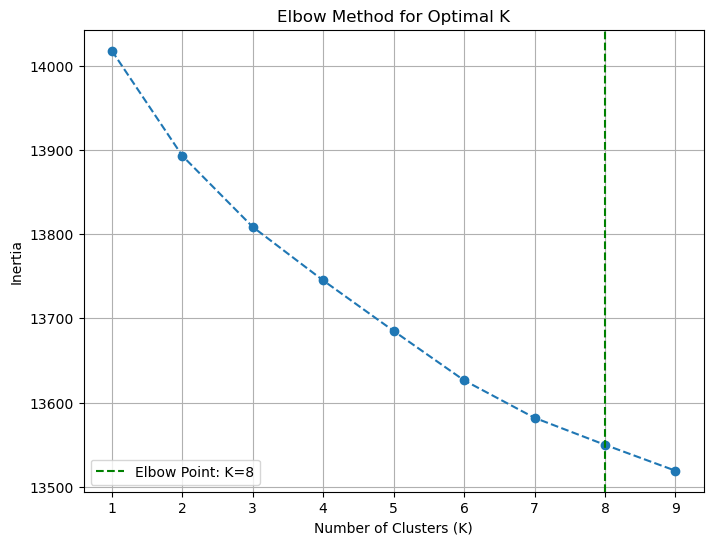

Optimal number of clusters (elbow point): 8


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Range of clusters to try
k_range = range(1, 10)

# List to store inertia values for each K
inertia = []

# Calculate inertia for each K
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)  # Set n_jobs=1 to disable parallelism
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Calculate the first derivative (difference between successive inertia values)
inertia_diff = np.diff(inertia)

# Find the index where the first derivative decreases the most (elbow point)
elbow_point = np.argmax(inertia_diff) + 1  # Adding 1 because the first diff is one less than the actual K

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.axvline(x=elbow_point, color='g', linestyle='--', label=f"Elbow Point: K={elbow_point}")
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.legend()
plt.show()

print(f"Optimal number of clusters (elbow point): {elbow_point}")

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Clustering using K-Means
num_clusters = elbow_point  # Set the number of clusters (You can adjust this based on evaluation metrics)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.labels_

# Evaluate clustering using silhouette score
sil_score = silhouette_score(X, labels)

# Show the results
print(f"Silhouette Score: {sil_score}")

# Extract the top 10 words for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# Display the top 10 words in each cluster
for i in range(num_clusters):
    print(f"Cluster {i+1} top 10 words:")
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(", ".join(top_words))
    print("\n")

Silhouette Score: 0.010575737867006546
Cluster 1 top 10 words:
european, need, mr, climate, commission, member, eu, state, union, new


Cluster 2 top 10 words:
woman, right, violence, abortion, gender, girl, equality, men, sexual, afghanistan


Cluster 3 top 10 words:
european, right, mr, union, law, president, people, parliament, country, state


Cluster 4 top 10 words:
energy, gas, price, european, need, crisis, renewable, market, electricity, nuclear


Cluster 5 top 10 words:
health, child, young, youth, mental, people, cancer, european, education, care


Cluster 6 top 10 words:
vote, agenda, point, follows, session, rsp, minute, request, voting, committee


Cluster 7 top 10 words:
closed, discussion, written, statement, article, vote, ended, thursday, held, debate


Cluster 8 top 10 words:
ukraine, war, russia, putin, russian, ukrainian, european, people, europe, country




## Question 3

In [21]:
from sklearn.decomposition import PCA

In [22]:
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X.toarray())

In [24]:
X_pca.shape

(14494, 2)

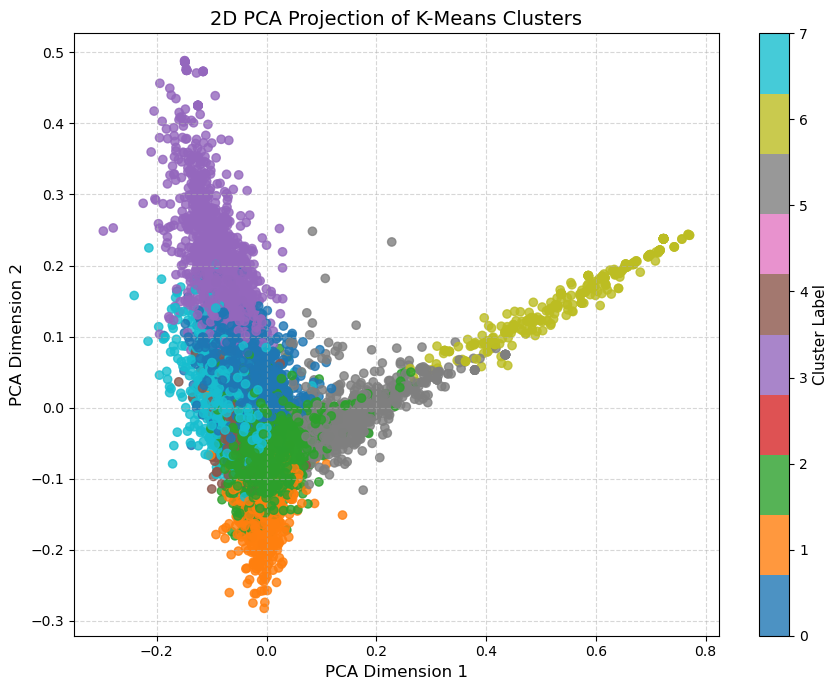

In [27]:
import matplotlib.pyplot as plt

# Define a new color map and marker
plt.figure(figsize=(9, 7))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmeans.labels_,
    cmap='tab10',   
    marker='o',     
    alpha=0.8
)

plt.title("2D PCA Projection of K-Means Clusters", fontsize=14)
plt.xlabel("PCA Dimension 1", fontsize=12)
plt.ylabel("PCA Dimension 2", fontsize=12)
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster Label", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [26]:
# Get the components and feature names
components = pca.components_
feature_names = vectorizer.get_feature_names_out()

# Top 10 contributing terms to PC1 and PC2
top_n = 20

pc1_top_indices = components[0].argsort()[::-1][:top_n]
pc2_top_indices = components[1].argsort()[::-1][:top_n]

print("Top words for PC1:")
print([feature_names[i] for i in pc1_top_indices])

print("\nTop words for PC2:")
print([feature_names[i] for i in pc2_top_indices])

Top words for PC1:
['closed', 'vote', 'discussion', 'statement', 'written', 'article', 'thursday', 'agenda', 'held', 'ended', 'tomorrow', 'debate', 'place', 'tuesday', 'point', 'follows', 'wednesday', 'submitted', 'minute', 'session']

Top words for PC2:
['energy', 'price', 'gas', 'closed', 'written', 'discussion', 'crisis', 'statement', 'supply', 'renewable', 'electricity', 'vote', 'market', 'need', 'article', 'climate', 'nuclear', 'fossil', 'green', 'food']
